# Vector analysis

analyzing wind vectors. code by Noel Wang, based on other stuff in AK_polynya environment

## importing packages

In [164]:
# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
from matplotlib import colors as mcolors

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat

# for use in suppressing repeated warnings when mapping w/ shapely
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# path to own functions
sys.path.append('../Libraries_functions/')
from LIB_ASI_SIC_UniB import grab_ASI_SIC, grab_projinfo_SIC
from LIB_geo_func import *
from LIB_geo_plot import *


# OSI SAF sea ice drift
from LIB_OSI_SAF import grab_projinfo_OSISAF, grab_OSISAF_drift

# NSIDC sea ice drift
from LIB_PPdrift_NSIDC0116 import grab_projinfo_PPdrift

# ERA5
# from LIB_access_ERA5 import grab_ERA5

%load_ext autoreload
%autoreload 2
# potentially uninstall pyhdf?

# math
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## determining The Vector

In [182]:
year = 2024

# importing the CSV files

#read in the data files
df_hourly_wind = pd.read_csv(f"/Users/reu/Box/Data/{year}hourly_wind.csv")
df_daily_size = pd.read_csv(f"/Users/reu/Box/Data/{year}SIC.csv")
df_daily_wind = pd.read_csv(f"/Users/reu/Box/Data/{year}daily_wind.csv")

#converting the times to the correct format
time_daily = pd.to_datetime(df_daily_size.time)
time_hourly = pd.to_datetime(df_hourly_wind.time)

#initialize an empty list
angles_list = []
mag_list = []

#make dictionary of the u:v values
uv_list = list(zip(df_hourly_wind.u10_average_m_s, df_hourly_wind.v10_average_m_s))

#calculate the angle and magnitude with trigonometry
i = 0
while i < len(df_hourly_wind):
    angle =math.degrees((np.arctan2(df_hourly_wind.v10_average_m_s[i], df_hourly_wind.u10_average_m_s[i]))) % 360
    # print(f'The angle in iteration {i} is {angle}, calculated by taking {df_hourly_wind.v10_average_m_s[i]} / {(df_hourly_wind.u10_average_m_s[i])}')
    angles_list.append(angle)
    
    mag = np.linalg.norm(uv_list[i])
    mag_list.append(mag)
    
    i +=1

#rcostheta = u, rsintheta = v. r = 17 m/s. theta = 157.5 degrees
theVector = [17* math.cos(math.radians(157.5)), 17* math.sin(math.radians(157.5))]
print(theVector)

#calculate the projection
i = 0
proj_list = []
while i < len(uv_list):
    proj = np.dot(uv_list[i], theVector) / np.linalg.norm(theVector)
    proj_list.append(proj)
    i+=1

[-15.705952052691874, 6.505618350206527]


/var/folders/1y/8_442fb923bb526xtrg6y2p80000gr/T/ipykernel_14005/3169199508.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_daily = pd.to_datetime(df_daily_size.time)


In [183]:
#including Jan 31st
d = {'time': time_hourly, 'angle': angles_list, 'mag': mag_list, 'u': df_hourly_wind.u10_average_m_s, 'v': df_hourly_wind.v10_average_m_s, 'projlist': proj_list}
df = pd.DataFrame(data=d)
df.to_csv(f'/Users/reu/Box/Data/{year}angles.csv', index=None) #removes Index column

Text(0.5, 0.98, 'Stacked angles plot from 01-Jan-2024 to 31-Jan-2024 over polynya')

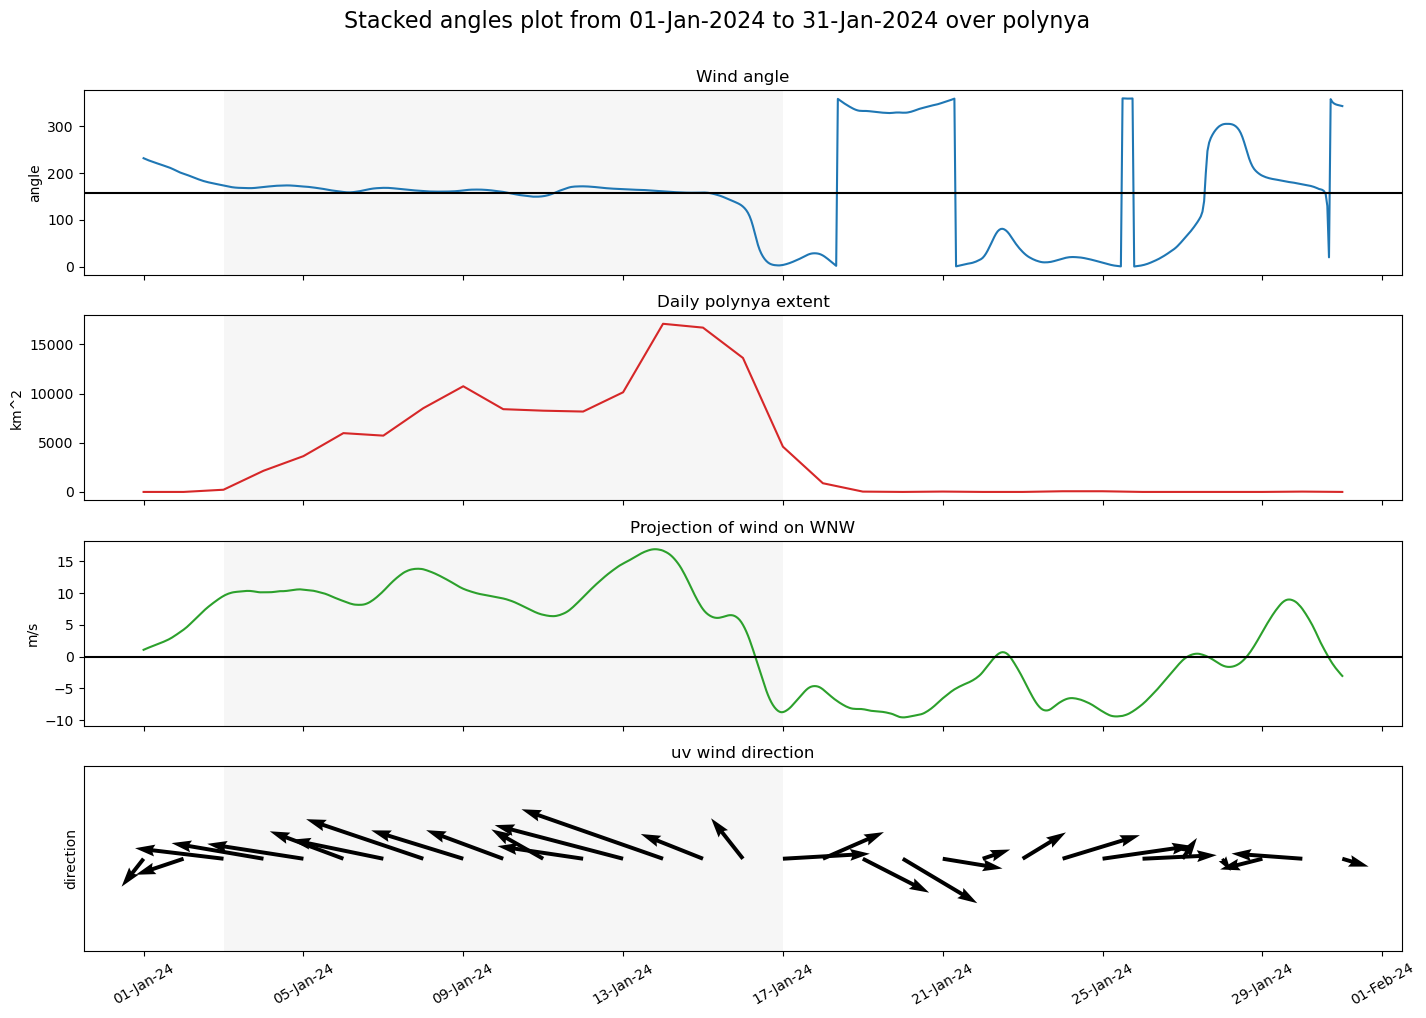

In [186]:
#plot stacked plots

fig, ax = plt.subplots(4, 1, figsize = (14,10))

labeldata = ("angle", "km^2", "m/s", "direction")

for i, (unit) in enumerate(labeldata):
    ax[i].set_ylabel(unit)
    ax[i].axvspan(datetime(2024, 1,3), datetime(2024, 1, 17), facecolor='lightgray', alpha=0.2)

plt.tight_layout()
fig.subplots_adjust(top=.9)

ax[0].plot(time_hourly, angles_list, 'tab:blue', label='uv wind (m/s)')
ax[0].set_title('Wind angle')
ax[0].axhline(157.5, color = 'black')
# ax[0].set_ylim(0,20)

ax[1].plot(time_daily, df_daily_size.Open_water_extent_km2, 'tab:red', label = 'open water extent (km^2)')
ax[1].set_title('Daily polynya extent')

ax[2].plot(time_hourly, proj_list, 'tab:green')
ax[2].set_title('Projection of wind on WNW')
ax[2].axhline(0, color = 'black')

y = np.zeros_like(time_daily)
qv = plt.quiver(time_daily, y, df_daily_wind.u10_average_m_s, df_daily_wind.v10_average_m_s, width=0.003)
qk = ax[3].quiverkey(qv, 10, 10, 5, r'$20 \frac{km}{day}$',labelpos='E' )
ax[3].set_title('uv wind direction')
ax[3].set_yticks([])

for ax in ax.flat:
    ax.label_outer()

plt.xticks(rotation=30)
# plt.xticks(time_daily)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))

plt.suptitle(f'Stacked angles plot from {time_daily[0].strftime("%d-%b-%Y")} to {time_daily[len(time_daily) - 1].strftime("%d-%b-%Y")} over polynya', fontsize=16)
#highlighting the polynya formation

In [ ]:
#layered
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('time')
ax1.set_ylabel('polynya extent km2')
ax1.plot(time_daily, df_daily_size.Open_water_extent_km2, color = color)
ax1.tick_params(axis = 'y', labelcolor = color)
ax1.plot(time_hourly, angles_list, 'tab:blue', label='uv wind (m/s)')

# plt.axis('scaled')


In [108]:
math.degrees(np.arctan2(-1,-1))

-135.0

In [72]:
averagers = [353.157652436921,354.344072 , 355.3992679, 354.46230707747, 356.481335420866 , 359.104098127688]
np.average(averagers)

355.4914554938241